$\textbf{GOAL :}$ We want to see if we can find better local minima by using MM, SCA and dual certificate.
We focus on the loss function $\sqrt{RSS}$ and $P_\nu$ as penalty non convex. 

In [1]:
using LinearAlgebra, Statistics, Random, Printf, Plots, LaTeXStrings

# Initial setup

## Lambda_qut

In [2]:
function lambda_local0(y, X; verbose=false)
    r = y .- mean(y)
    if verbose
        @printf("residu norm : %.12f\n", norm(r))
    end
    return maximum(abs.(X' * r)) / norm(r)
end

function lambda_qut_v(X; α=0.05, M=1000, rng=Random.GLOBAL_RNG, verbose=false)
    n = size(X,1)
    λvals = Vector{Float64}(undef, M)
    for m in 1:M
        y0 = randn(rng, n)
        λvals[m] = lambda_local0(y0, X; verbose=verbose)
    end
    return quantile!(λvals, 1-α)
end

lambda_qut_v (generic function with 1 method)

In [20]:
function rho(x::AbstractVector{Float64}, ν::Float64)
    return sum(rho.(x, ν))  # Apply scalar rho to each element and sum
end
function rho(x::Float64, ν::Float64)  
    return abs(x) / (1 + abs(x)^(1-ν))
end

rho_prime(x, ν) = (1 + ν*abs(x)^(1-ν)) / (1 + abs(x)^(1-ν))^2 

rho_prime (generic function with 1 method)

In [4]:
include("../functions/metrics.jl")

import .metrics: pesr, tpr, fdr, f1score

## ISTA

In [ ]:
include("../functions/ISTA.jl")

import .ISTA: ista_L, ista

In [5]:
function bisection(f, a, b; tol=1e-10, maxiter=1000, verbose=false)
    if f(a)==0
        return a, 0
    end
    if f(b)==0
        return b, 0
    end
    
    if verbose
        @printf("start with a = %.12f : f(a) = %.12f, b = %.12f : f(b) = %.12f\n", a, f(a), b, f(b))
    end
    fa, fb = f(a), f(b)
    # TODO : attention ! special pour ce cas et se rappeler pourquoi
    while f(a)*f(b)>0
        b*=2
        if b> 1e10
            return a, -1
        end
        
    end
    # @assert fa * fb < 0 "Need f(a)f(b)<0 : $(fa) | $(fb)"
    for k in 1:maxiter
        m  = 0.5*(a+b)
        fm = f(m)
        if abs(fm) <= tol || 0.5*(b-a) <= tol
            if verbose
                @printf("bisection: found %.12f in %d iterations | a = %.12f, b = %.12f, f(a) = %.12f, f(b) = %.12f\n", m, k, a, b, fa, fb)
            end
            return m, k
        elseif fm>0
            b, fb = m, fm
        else
            a, fa = m, fm
        end
    end
    error("No convergence in $maxiter iterations")
end

bisection (generic function with 1 method)

In [ ]:
function kappa_phi(Γ::Float64, ν::Float64)
    T = eps(Float64)
    kappa_poly(κ) = κ^(2-ν) + 2κ + κ^ν + 2Γ*(ν-1) 
    κ, it = bisection(kappa_poly, 0.0, max(1.0, Γ*(1-ν)), verbose=false)
    φ = κ/2 +  Γ/(1 + κ^(1-ν))

    return κ, φ
end

In [ ]:
function x_tar(z::Float64, Γ::Float64, ν::Float64, κ::Float64)
    h(x) = x + Γ * rho_prime(x, ν) - z
    res, _ = bisection(h,κ,z; tol = 1e-10, verbose=false)
    return res
end

In [ ]:
function prox_harder_vec(z::AbstractVector, γ::Float64, λ::Float64, ν::Float64)
    if ν== 1.0 
        return sign.(z) .* max.(abs.(z) .- γ * λ*0.5, 0.0) # soft thresholding (see l_qut_1) # TODO page 4 harderLASSO pdf phi_1 (confirmer)
    end
    # else proximal operator for harder penalty
    Γ = γ * λ 
    κ, φ = kappa_phi(Γ, ν)    

    β_new = map(z[1:end-1]) do zi # coordinate loop
        abs(zi) ≤ φ - eps() ? 0.0 : sign(zi) * x_tar(abs(zi), Γ, ν, κ) 
    end
    return vcat(β_new, z[end])
end


# MM

## Theory

We want to solve an optimization problem of the form

$$
\min_{\theta \in \mathcal{D}} F(\theta) := f(\theta) + g(\theta)
$$

where: $\mathcal{D} \subseteq \mathbb{R}^p$ is the parameter domain, $f : \mathcal{D} \to \mathbb{R}$ differentiable almost everywhere, the loss function and $g : \mathcal{D} \to \mathbb{R} \cup {+\infty}\$ <span style="color:red"><b>relativement bien (localement lipschitzien, folded concave, etc...)</b></span>

The MM **principle** replaces $F$ with an easier surrogate at each iteration.


\textbf{Definition :} A function $G(\cdot \mid \theta^k)$ is a majorizer of $F$ at $\theta^k$ if
+  $G(\theta^k \mid \theta^k) = F(\theta^k)$ (Tangency)
+ $G(\theta \mid \theta^k) \ge F(\theta)$ for all $\theta \in \mathcal{D}$ (Majorization)

Hence we can design an algorithm on this idea to optimize at each iteration a new surrogate.

1. Start with an initial $\theta^0 \in \mathcal{D}$. 
2. For $k = 0,1,2,\dots$,
   $$
   \theta^{k+1} \in \arg\min_{\theta \in \mathcal{D}} G(\theta \mid \theta^k)
   $$  
3. Stop when a convergence criterion is met.




We got monotonic decrease,
  $$
  F(\theta^{k+1}) \le G(\theta^{k+1} \mid \theta^k) \le G(\theta^k \mid \theta^k) = F(\theta^k)
  $$

and we converge towards a local minimum of $F$ under mild assumption <span style="color:red"><b>TODO : find + source ; mais on les vérifie</b></span> 

1. **Bounded below**: $F(\theta) > -\infty$.
2. **Tangency & majorization**: $G$ satisfies the two properties above.
3. **Exact minimization** of $G(\cdot \mid \theta^k)$ (or sufficient descent in inexact MM).
4. **Continuity**: $G(\theta \mid \cdot)$ continuous in both arguments.
5. **Coercivity** (optional): ensures bounded iterates.
<!-- 
**Theorem 1** (Convergence to stationary points — *Hunter & Lange 2004*).
Let \${\theta^k}\$ be the sequence from MM with a continuous majorizer \$G\$. If:

* \$F\$ is bounded below,
* \${\theta^k}\$ is bounded,
* \$\theta^{k+1}\$ exactly minimizes \$G(\cdot \mid \theta^k)\$,

then every limit point \$\theta^\*\$ of \${\theta^k}\$ is a stationary point of \$F\$.

*Proof sketch*:
Monotonicity ensures \$F(\theta^k)\$ decreases and converges. Continuity of \$G\$ and boundedness of \${\theta^k}\$ allow extracting convergent subsequences. Tangency and optimality imply first-order stationarity. -->





## Our case ($\sqrt{RSS}$ and $P_\nu$)

We have $f = \sqrt{RSS}$ smooth function, we can therefore bounded with Taylor Expansion and local Lipschitz (hence we can take $L_{\partial f}  = \frac{|X|_2^2}{|y - X\theta^k|_2} $ ) <span style="color:red"><b>(?? verif)</b></span> 
$$
f(\theta) \le f(\theta^k) + \partial f(\theta^k)^\top (\theta - \theta^k) + \frac{L_{\partial f}}{2} \|\theta - \theta^k\|_2^2
$$

Then $g=P_\nu$. We decompose as difference of convex functions, <span style="color:red"><b>plus intelligent à faire ?</b></span>  $$g = ||\cdot||_1 - \underbrace{(||\cdot||_1 - P_\nu)}_{:=\,h}$$ 
Thus, by convexity of $h$ (and so concavity of $-h$), for $s^k \in \partial h(\theta^k)$

$$
g(\theta) \le \|\theta\|_1 - h_\nu(\theta^k) - (s^k)^\top (\theta - \theta^k)
$$

We define the surrogate,

$$
G(\theta, \theta^k) := f(\theta^k) + \partial f(\theta^k)^\top (\theta - \theta^k) + \frac{L_{\partial f}}{2} \|\theta - \theta^k\|_2^2 + \lambda \left( \|\theta\|_1 - h(\theta^k) - (s^k)^\top (\theta - \theta^k) \right)
$$

We are interested only by its argmin, we remove constant according to $\theta$. We simplify it as, 

$$
G(\theta, \theta^k) := \frac{L_{\partial f}}{2} \|\theta - \theta^k\|_2^2 + \left(\partial f(\theta^k)  - \lambda s^k \right)^\top(\theta - \theta^k)+ \lambda \|\theta\|_1
$$

Now we can develop quadratic term,
$$
G(\theta, \theta^k) =  \frac{L}{2} \theta^\top \theta - L (\theta^k)^\top \theta + \frac{L}{2} \|\theta^k\|_2^2 +  (\partial f(\theta^k) - \lambda s^k)^\top \theta - (\partial f(\theta^k) - \lambda s^k)^\top \theta^k + \lambda \|\theta\|_1
$$


Then,
$$
G(\theta, \theta^k) =
\frac{L}{2} \theta^\top \theta
+ \Big[ -L \theta^k + \partial f(\theta^k) - \lambda s^k \Big]^\top \theta
+ \lambda \|\theta\|_1
$$

$$
\quad + \underbrace{\frac{L}{2} \|\theta^k\|_2^2 - (\partial f(\theta^k) - \lambda s^k)^\top \theta^k}_{\text{independents terms according to }\theta}.
$$

To conclude, we can write G as,
$$
G(\theta, \theta^k) =
\frac{L}{2} \left\| \theta - \left( \theta^k - \frac{1}{L} [\partial f(\theta^k) - \lambda s^k] \right) \right\|_2^2
+ \lambda \|\theta\|_1 + constante
$$


And surprinsgly we get, with $v_k := \theta^k - \frac{1}{L} [\partial f(\theta^k) - \lambda s^k]$
$$
\theta^{k+1} = \argmin_\theta G(\theta, \theta^k ) = \operatorname{prox}_{\frac{1}{L}, \lambda ||\cdot||_1}(\theta^k   - \frac{1}{L} [\partial f(\theta^k) - \lambda s^k])
= \bigotimes_{i=1}^p\operatorname{sign}([v_k]_i)\max{|[v_k]_i|-\frac{\lambda}{L}, 0}
$$


## Experiments

In [1]:
soft_threshold(x, τ) = sign.(x) .* max.(abs.(x) .- τ, 0.0)

h_value(x, nu) = sum(abs.(x)) .- rho(x, nu)
function h_subgrad(x, nu)
    result = similar(x)

    for i in 1:length(x)
        if x[i] == 0.0
            result[i] = 0.0  # in [-1,1]
        else
            result[i] = sign(x[i]) * (1-rho_prime(x[i], nu))    
        end
    end
    
    return result
end

h_subgrad (generic function with 1 method)

In [55]:
function MM(f, grad_f, X̃, y, λ; theta0, nu,
            max_iter::Int=1000, tol::Float64=1e-6,
            keep_trace=false, verbose=true)

    n, P = size(X̃)           # X̃ = [X 1], last col = intercept
    p = P - 1                 # penalized block: 1:p

    ρ(θ)      = rho(θ[1:p], nu)                # penalty only on 1:p
    h_val(θ)  = h_value(view(θ, 1:p), nu)
    function svec(θ)
        s = zeros(eltype(θ), P)
        s[1:p] .= h_subgrad(view(θ, 1:p), nu)        # no subgrad on intercept
        return s
    end

    F(x) = f(x) + λ * ρ(x)

    θ = copy(theta0)
    obj_trace = keep_trace ? Float64[] : nothing

    for k in 1:max_iter
        gk = grad_f(θ)                               # must match f (no δ)
        s_k = svec(θ)

        rnorm = norm(y - X̃*θ)
        if rnorm == 0.0
            return keep_trace ? (θ, k, obj_trace) : (θ, k)
        end

        Lk = opnorm(X̃)^2 / rnorm
        γ  = 1.0 / Lk

        # gradient step + linearization of -λ h_ν
        v = θ .- γ .* (gk .- λ .* s_k)

        # prox: soft-threshold ONLY on 1:p; intercept untouched
        θ_new = copy(v)
        θ_new[1:p] .= soft_threshold(v[1:p], λ*γ)
        # θ_new[end] = v[end]  # already true

        d = θ_new .- θ

        # Majorizer Q (with the DC linearization on 1:p only)
        Q = f(θ) + dot(gk, d) + 0.5 * Lk * dot(d, d) +
            λ * (sum(abs.(θ_new[1:p])) - h_val(θ) - dot(s_k[1:p], d[1:p]))

        F_new = F(θ_new)
        
        
        if keep_trace
            push!(obj_trace, F_new)
        end
        if verbose
            println("Q = $Q,  F(theta_new) = $F_new, diff_val = $(Q - F_new),‖diff_theta‖ = $(norm(d)),  Lk = $Lk,  γ = $γ")
            # @info "MM iter=$k  F=$F_new  Lk=$Lk  step_norm=$(norm(d))"
        end

        if norm(d) ≤ tol
            return keep_trace ? (θ_new, k, obj_trace) : (θ_new, k)
        end
        θ = θ_new
    end

    return keep_trace ? (θ, max_iter, obj_trace) : (θ, max_iter)
end


MM (generic function with 1 method)

In [59]:
# derivative wrt t≥0 for ρν(t) = t / (1 + t^(1-ν))
rho_prime_abs(t, ν) = (1 + ν * t^(1-ν)) / (1 + t^(1-ν))^2

function MM_IRL1(f, grad_f, X̃, y, λ; theta0, nu,
                 max_iter::Int=1000, tol::Float64=1e-6,
                 keep_trace=false, verbose=true)

    n, P = size(X̃)             # X̃ = [X ones]
    p     = P - 1               # penalized block: 1:p
    Xop2  = opnorm(X̃)^2        # cache

    # Pν(θ) on penalized coords only
    Pν(θ) = begin
        a = abs.(θ[1:p])
        sum( a ./ (1 .+ a .^ (1 - nu)) )
    end

    F(θ) = f(θ) + λ * Pν(θ)

    θ = copy(theta0)
    obj_trace = keep_trace ? Float64[] : nothing

    for k in 1:max_iter
        gk = grad_f(θ)

        rnorm = norm(y - X̃*θ)
        if rnorm == 0.0
            return keep_trace ? (θ, k, obj_trace) : (θ, k)
        end

        Lk = Xop2 / rnorm
        γ  = 1.0 / Lk

        # IRL1 weights: w_i = ρν'( |θ_i| )
        w = rho_prime_abs.(abs.(θ[1:p]), nu)    # each in (0,1]

        # gradient step on f
        v = θ .- γ .* gk

        # weighted soft-threshold on penalized block; intercept untouched
        θ_new = copy(v)
        τ = (λ * γ) .* w
        θ_new[1:p] .= sign.(v[1:p]) .* max.(abs.(v[1:p]) .- τ, 0.0)
        # θ_new[end] = v[end]

        d = θ_new .- θ

        # Optional majorizer (for monitoring):
        Pθ    = Pν(θ)
        Qpen  = λ * ( dot(w, abs.(θ_new[1:p])) + (Pθ - dot(w, abs.(θ[1:p]))) )
        Q     = f(θ) + dot(gk, d) + 0.5 * Lk * dot(d, d) + Qpen
        F_new = F(θ_new)

        if keep_trace
            push!(obj_trace, F_new)
        end
        if verbose && (k == 1 || k % 50 == 0)
            println("Q = $Q,  F(theta_new) = $F_new,  diff = $(Q - F_new),  ‖d‖ = $(norm(d)),  Lk = $Lk,  γ = $γ")
        end

        # stopping
        if norm(d) ≤ tol
            return keep_trace ? (θ_new, k, obj_trace) : (θ_new, k)
        end

        θ = θ_new
    end

    return keep_trace ? (θ, max_iter, obj_trace) : (θ, max_iter)
end


MM_IRL1 (generic function with 1 method)

### Phase transition

In [66]:
function run_trial_nu_mm(X, β, σ, ν; α=0.05, tol=1e-6, max_iter=10_000, mu=1., c=0., verbose=false)
    n = size(X, 1)
    X̃ = hcat(X, ones(n)) # Ajout colonne d'intercept
    y = X * β .+ σ * mu *randn(n) .+ c
    
    λ_QUT = lambda_qut_v(X; α = α, M = 1000, verbose = false)

    f(θ) = norm(y - X̃ * θ, 2)
    ∇f(θ) = X̃'*(X̃*θ-y) / norm(X̃ * θ - y, 2)
  
    L0 = 1e-4
    θ  = zeros(p + 1)  
    
    θ, _ = MM(f, ∇f,X̃, y, λ_QUT; theta0 = θ, nu = ν,
            max_iter = max_iter, tol = tol,
            keep_trace = false, verbose = verbose)

    return θ[1:p]       
end

function phase_transition_nu_mm(n, p, s_list, ν; σ=0.1, B=20, α=0.05, tol=1e-8, seed=42, verbose=false)
    m = length(s_list)
    pesr_rate = zeros(m)
    f1_rate = zeros(m)
    fdr_rate = zeros(m)
    tpr_rate = zeros(m)

    Random.seed!(42)

    for (i, s) in enumerate(s_list)
        acc_pesr = acc_f1 = acc_fdr = acc_tpr = 0.0

        for _ in 1:B
            X = randn(n, p)
            X .-= mean(X; dims=1)
            X ./= std(X;  dims=1)

            β = zeros(p)
            β[randperm(p)[1:s]] .= 3
            β_hat = run_trial_nu_mm(X, β, σ, ν; α=α, tol=tol, c=0, verbose=verbose)

            y, ŷ = abs.(β) .> 0, abs.(β_hat) .> 0

            acc_pesr += pesr(β, β_hat; tol=0)
            acc_f1 += f1score(y, ŷ)
            acc_fdr += fdr(y, ŷ)
            acc_tpr += tpr(y, ŷ)
        end

        pesr_rate[i] = acc_pesr/B
        f1_rate[i] = acc_f1 /B
        fdr_rate[i] = acc_fdr/B
        tpr_rate[i] = acc_tpr/B
    end

    return s_list, pesr_rate, f1_rate, fdr_rate, tpr_rate
end

phase_transition_nu_mm (generic function with 1 method)

In [ ]:
n, p = 70, 250
s_lst = 0:15
B_trial = 5
sigma = 0.1
ν = 0.1

s, pesr_r, f1_r, fdr_r, tpr_r = phase_transition_nu_mm(n, p, s_lst, ν; σ=sigma, B=B_trial, tol=1e-9, verbose=false)

Q = 0.7900282951141453,  F(theta_new) = 0.7900279505384119, diff_val = 3.4457573339086167e-7,‖diff_theta‖ = 3.388935917872263e-5,  Lk = 688.6545074463003,  γ = 0.0014521069552107416
Q = 0.7900276502968581,  F(theta_new) = 0.790027388685093, diff_val = 2.61611765028924e-7,‖diff_theta‖ = 2.9529051467001086e-5,  Lk = 688.6551525198737,  γ = 0.0014521055950004547
Q = 0.790027160733103,  F(theta_new) = 0.790026962109992, diff_val = 1.9862311095852903e-7,‖diff_theta‖ = 2.5729754166855685e-5,  Lk = 688.6556422790752,  γ = 0.0014521045622897164
Q = 0.7900267890423396,  F(theta_new) = 0.7900266382420298, diff_val = 1.5080030979497394e-7,‖diff_theta‖ = 2.2419285977628395e-5,  Lk = 688.6560141187266,  γ = 0.0014521037782262026
Q = 0.7900265068441491,  F(theta_new) = 0.7900263923522799, diff_val = 1.1449186920753363e-7,‖diff_theta‖ = 1.9534752663675356e-5,  Lk = 688.6562964302451,  γ = 0.0014521031829428592
Q = 0.7900262925912841,  F(theta_new) = 0.7900262056658184, diff_val = 8.692546571431592e-8

Excessive output truncated after 524331 bytes.

Q = 3.7556252336034355,  F(theta_new) = 3.7556252336009566, diff_val = 2.4789059693830495e-12,‖diff_theta‖ = 9.065833314913505e-8,  Lk = 687.0890865530895,  γ = 0.0014554153450707338
Q = 3.7556252335987814,  F(theta_new) = 3.755625233596874, diff_val = 1.907363156306019e-12,‖diff_theta‖ = 7.955857410982332e-8,  Lk = 687.08911237678,  γ = 0.001455415290370121
Q = 3.7556252335952,  F(theta_new) = 3.7556252335937295, diff_val = 1.4703793738135573e-12,‖diff_theta‖ = 6.98178142817895e-8,  Lk = 687.0891350382684,  γ = 0.001455415242367795
Q = 3.755625233592439,  F(theta_new) = 3.7556252335913083, diff_val = 1.1306511282782594e-12,‖diff_theta‖ = 6.126966529363626e-8,  Lk = 687.0891549248286,  γ = 0.0014554152002434176
Q = 3.7556252335903153,  F(theta_new) = 3.755625233589443, diff_val = 8.72191208145523e-13,‖diff_theta‖ = 5.3768109275829967e-8,  Lk = 687.0891723762932,  γ = 0.0014554151632771434
Q = 3.7556252335886775,  F(theta_new) = 3.755625233588007, diff_val = 6.705747068735946e-13,‖diff_

(0:15, [1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 0.8, 0.2, 0.2, 0.4, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 1.0, 1.0, 1.0, 0.9818181818181818, 1.0, 1.0, 0.8800000000000001, 0.31272727272727274, 0.43533799533799533, 0.6047619047619047, 0.31251885369532423, 0.1569047619047619, 0.167843137254902, 0.09166666666666666], [0.0, 0.0, 0.0, 0.0, 0.0, 0.03333333333333333, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.2, 0.0], [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.85, 0.2666666666666667, 0.36, 0.5272727272727271, 0.21666666666666665, 0.09230769230769231, 0.1, 0.05333333333333333])

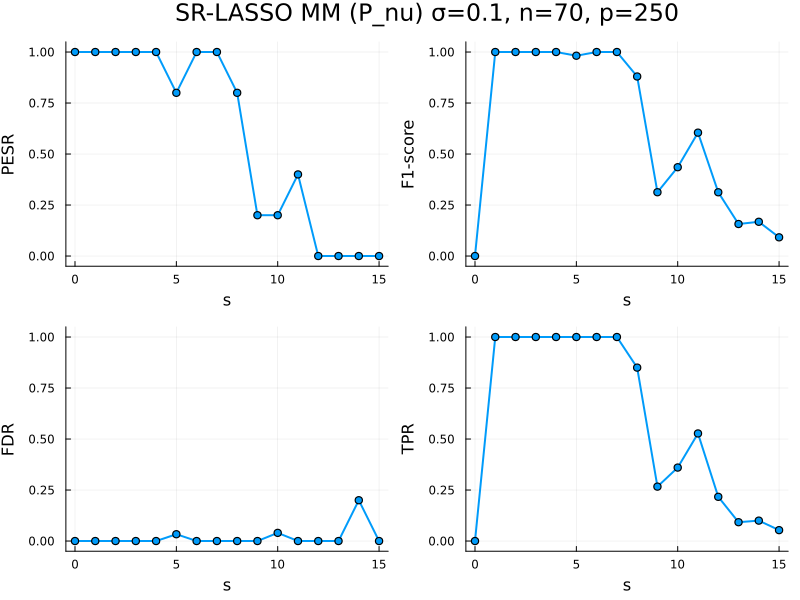

In [68]:
main_title = "SR-LASSO MM (P_nu) σ=$sigma, n=$n, p=$p"
plot(
    plot(s, pesr_r; xlabel="s", ylabel="PESR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, f1_r; xlabel="s", ylabel="F1-score", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, fdr_r; xlabel="s", ylabel="FDR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, tpr_r; xlabel="s", ylabel="TPR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    layout =(2, 2), size = (800, 600), plot_title=main_title
)

We introduce MM and MM_IRL1, suggest by chatGPT as another surrogate (linearizing $P_\nu$ directly leading to the reweighted $\ell_1$ minimization (see Candes works)). Nonetheless, we don't get the same result than from ISTA because our surrogate modify too much the landscape of our cost function and doesn't deal with the non convexity of our penalty whereas the implicit expression of proximal allows to capt more informations. This leads to find better attractor bassin.

**ERRORS in the method can still persist !**  
We doesn't have test to know if it works or not. Our conclusion has to be taken with a pinch of salt !

# SCA

## Theory

More general than MM : ou surrogate no longer majorize objective function $F$ but it satisfies some first-order consistency properties that ensure asymptotic convergence.

## Experiments

In [81]:
# ---------- P_ν and its exact prox ----------
# ρν(t) = t / (1 + t^(1-ν)), t≥0
rho_prime_abs(t, ν) = (1 + ν * t^(1-ν)) / (1 + t^(1-ν))^2

# scalar prox of τ Pν at v: solve x + τ ρ'(x) = |v|  for x∈[0,|v|]
function prox_pnu_scalar(v::Float64, τ::Float64, ν::Float64; itmax::Int=60, tol::Float64=1e-12)
    s = sign(v); a = abs(v)
    if a <= τ                      # since ρ'(0)=1 ⇒ threshold = τ
        return 0.0
    end
    lo, hi = 0.0, a
    α = 1 - ν
    @inbounds for _ in 1:itmax
        mid = 0.5*(lo+hi)
        tα  = mid^α
        rp  = (1 + ν*tα) / (1 + tα)^2
        g   = mid + τ*rp - a
        if abs(g) <= tol*(1+a)
            return s*mid
        end
        if g > 0.0; hi = mid else lo = mid end
    end
    return s*0.5*(lo+hi)
end

function prox_pnu_vec!(z::AbstractVector{<:Float64}, τ::Float64, ν::Float64)
    @inbounds for i in eachindex(z)
        z[i] = prox_pnu_scalar(z[i], τ, ν)
    end
    return z
end

# ---------- loss, grad (consistent, no δ) ----------
# f(θ) = ‖y - X̃θ‖2 ;  ∇f(θ) = X̃' (X̃θ - y) / ‖X̃θ - y‖2
grad_f_sr!(g::AbstractVector, θ::AbstractVector, X̃::AbstractMatrix, y::AbstractVector) = begin
    r = X̃*θ .- y
    nr = norm(r)
    @assert nr > 0.0 "Residual norm is zero at current θ; already a minimizer for f."
    mul!(g, X̃', r)          # g = X̃' r
    g ./= nr
    return nr                # return ‖r‖ for Lipschitz bound
end

# ---------- SCA with exact prox of Pν (tight surrogate) ----------
function SCA_Pnu(X̃::AbstractMatrix{<:Float64}, y::AbstractVector{<:Float64},
                 λ::Float64, ν::Float64; θ0::AbstractVector,
                 max_iter::Int=2000, tol::Float64=1e-6,
                 L0::Float64=1.0, bt_mult::Float64=2.0, verbose::Bool=false)

    n, P = size(X̃); p = P - 1
    @assert length(θ0) == P
    θ = copy(θ0)
    g = similar(θ)
    L = L0

    # objective
    Pν = θ -> sum(abs.(θ[1:p]) ./ (1 .+ abs.(θ[1:p]).^(1-ν)))
    F  = θ -> norm(y - X̃*θ) + λ*Pν(θ)

    for k in 1:max_iter
        nr = grad_f_sr!(g, θ, X̃, y)          # g = ∇f(θ), nr = ‖r‖
        # local Lipschitz bound for ∇f on joint (θ, intercept included)
        Lk = opnorm(X̃)^2 / nr
        L  = max(L, Lk)                        # start from conservative L

        # monotone backtracking on composite surrogate
        accepted = false
        θ_new = similar(θ)
        dnorm = 0.0
        while !accepted
            γ = 1.0 / L
            @. θ_new = θ - γ*g                 # forward step on f
            # exact nonconvex prox on penalized block
            prox_pnu_vec!(view(θ_new, 1:p), λ*γ, ν)
            # intercept untouched

            d = θ_new .- θ
            dnorm = norm(d)
            Q = norm(y - X̃*θ) + dot(g, d) + 0.5*L*dot(d, d) + λ*Pν(θ_new)
            Fnew = F(θ_new)
            if Fnew <= Q + 1e-12*(1+abs(Fnew))
                accepted = true
            else
                L *= bt_mult
            end
        end

        if verbose && (k==1 || k%50==0)
            @info "iter=$k  F=$(F(θ_new))  L=$L  step=$dnorm"
        end
        if dnorm <= tol
            return θ_new, k
        end
        θ = θ_new
        # mild decrease of L to allow larger steps next iter
        L = max(L/1.5, Lk)
    end
    return θ, max_iter
end


SCA_Pnu (generic function with 1 method)

In [ ]:
function run_trial_nu_sca(X, β, σ, ν; α=0.05, tol=1e-6, max_iter=10_000, mu=1., c=0., verbose=false)
    n = size(X, 1)
    X̃ = hcat(X, ones(n)) # Ajout colonne d'intercept
    y = X * β .+ σ * mu *randn(n) .+ c
    
    λ_QUT = lambda_qut_v(X; α = α, M = 1000, verbose = false)

    f(θ) = norm(y - X̃ * θ, 2)
    ∇f(θ) = X̃'*(X̃*θ-y) / norm(X̃ * θ - y, 2)
  
    L0 = 1e-4
    θ  = zeros(p + 1)  
    
    θ, _ = SCA_Pnu(X̃, y, λ_QUT, ν; θ0 = θ,
            max_iter = max_iter, tol = tol,
            L0 = L0, bt_mult = 2.0, verbose = verbose)
            
    return θ[1:p]       
end

function phase_transition_nu_sca(n, p, s_list, ν; σ=0.1, B=20, α=0.05, tol=1e-8, seed=42, verbose=false)
    m = length(s_list)
    pesr_rate = zeros(m)
    f1_rate = zeros(m)
    fdr_rate = zeros(m)
    tpr_rate = zeros(m)

    Random.seed!(42)

    for (i, s) in enumerate(s_list)
        acc_pesr = acc_f1 = acc_fdr = acc_tpr = 0.0

        for _ in 1:B
            X = randn(n, p)
            X .-= mean(X; dims=1)
            X ./= std(X;  dims=1)

            β = zeros(p)
            β[randperm(p)[1:s]] .= 3
            β_hat = run_trial_nu_sca(X, β, σ, ν; α=α, tol=tol, c=0, verbose=verbose)

            y, ŷ = abs.(β) .> 0, abs.(β_hat) .> 0

            acc_pesr += pesr(β, β_hat; tol=0)
            acc_f1 += f1score(y, ŷ)
            acc_fdr += fdr(y, ŷ)
            acc_tpr += tpr(y, ŷ)
        end

        pesr_rate[i] = acc_pesr/B
        f1_rate[i] = acc_f1 /B
        fdr_rate[i] = acc_fdr/B
        tpr_rate[i] = acc_tpr/B
    end

    return s_list, pesr_rate, f1_rate, fdr_rate, tpr_rate
end

phase_transition_nu_sca (generic function with 1 method)

In [ ]:
n, p = 70, 250
s_lst = 0:1
B_trial = 1
sigma = 0.1
ν = 0.1

s, pesr_r, f1_r, fdr_r, tpr_r = phase_transition_nu_sca(n, p, s_lst, ν; σ=sigma, B=B_trial, tol=1e-9, verbose=true)

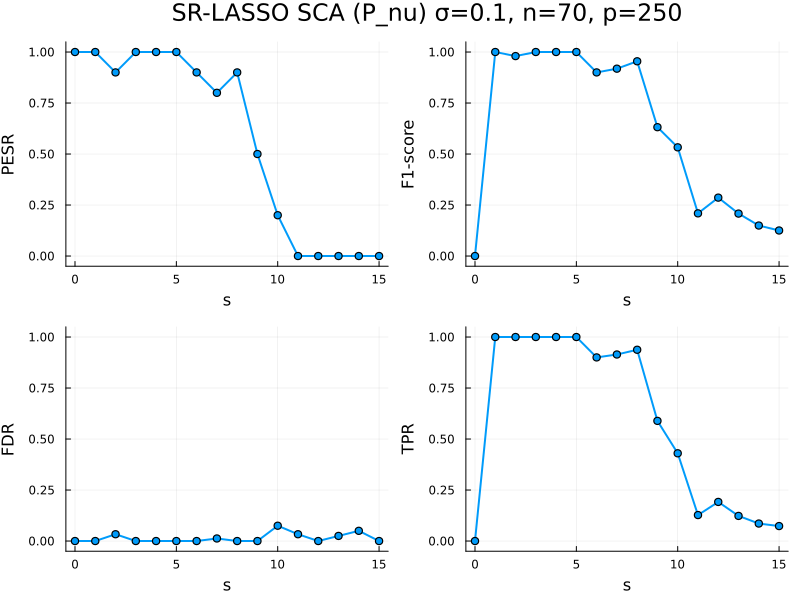

In [85]:
main_title = "SR-LASSO SCA (P_nu) σ=$sigma, n=$n, p=$p"
plot(
    plot(s, pesr_r; xlabel="s", ylabel="PESR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, f1_r; xlabel="s", ylabel="F1-score", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, fdr_r; xlabel="s", ylabel="FDR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    plot(s, tpr_r; xlabel="s", ylabel="TPR", legend=false, lw=2, marker=:circle, ylim=(0-0.05,1+0.05)),
    layout =(2, 2), size = (800, 600), plot_title=main_title
)

Conclusion has been written earlier. We have an implicit proximal for our penalty so use a surrogate add a bias and we fall inside bad local minimum. We can forget this approach.